# The Impact of Artificial Intelligence on Higher Education

### Introduction
Artificial intelligence (AI) is transforming higher education, influencing teaching, learning, and administrative practices. As AI becomes more prevalent in educational settings, there is a growing body of research examining its implications, benefits, and challenges in higher education. This notebook aims to explore this research landscape by conducting a two-part analysis.

### Part 1: Bibliometric Analysis
In the first phase, we perform a bibliometric analysis using data from SCOPUS, aiming to summarize the state of the research in this field. Specifically, our objectives include:
- **Quantifying Publication Trends ->** Determining how research on AI in higher education has grown over recent years.
- **Identifying Key Contributors ->** Recognizing influential authors, institutions, and countries that are leading research efforts.
- **Research Themes and Collaboration Networks ->** Exploring recurring themes, as well as collaborations and partnerships in the literature.

### Part 2: Text Mining Analysis
Following the bibliometric analysis, we will apply text mining techniques to the articles themselves. This phase will enable us to delve deeper into the content, uncovering nuanced insights into how AI is being discussed and understood in higher education contexts. In particular, we aim to:
- **Extract Key Topics ->** Use natural language processing (NLP) methods to identify key themes and subtopics.
- **Analyze Sentiment and Context ->** Examine how AI’s impact is portrayed in higher education, focusing on sentiments around its benefits and challenges.
- **Identify Emerging Trends ->** Detect emerging applications or innovative uses of AI in education.

### Methodology
We will use SCOPUS API to aquire articles based on the following search query:
``` "impact" AND "high* education" AND "artificial intelligence" AND PUBYEAR < 2025 ```. Our approach will follow these steps:
1. **Data collection ->** Retrieve bibliometric data from SCOPUS, including article titles, abstracts, authors, affiliations, and publication years.
2. **Data Processing ->** Organize and clean the data for analysis, ensuring it is suitable for quantitative and qualitative assessments.
3. **Bibliometric Analysis:**
    * **Publication Trends ->** Analyze the number of publications over time to identify growth patterns.
    * **Key Contributors ->** Identify leading authors, institutions, and countries in AI research within higher education.
    * **Research Themes ->** Use text mining techniques to uncover major themes and topics in the literature.
    * **Collaborative Networks ->** Examine co-authorship and institutional collaborations.
4. **Exploring Potential Machine Learning Applications ->** Briefly discuss potential applications of machine learning techniques to further analyze or extend insights from the bibliometric data.

### Expected outcomes
This analysis will contribute to understanding the broader impact of AI on higher education, offering valuable perspectives for academics, practitioners, and policymakers aiming to leverage AI technologies to enhance educational experiences and outcomes.


========================================================================================================================================

#### Importing required libraries and modules

In [65]:
import os
import sys
import requests
import json
import pickle
import math 
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Add custom module that provides auxiliar functions
aux_modules_path = os.path.abspath(os.path.join('./scripts'))
if aux_modules_path not in sys.path:
    sys.path.append(aux_modules_path)


#### API Key Configuration

In [ ]:
from dotenv import load_dotenv

load_dotenv()

API_KEY = os.getenv('API_KEY')

print(f"API Key: {API_KEY}")

API Key: dc7c18eddcd470e03ed6f72cf4a11585


#### Data Collection
This will take some time due to the high amount of articles retrieved. This will retrieve 5000 articles, even though the query results in over 50000 articles, due to SCOPUS API imposing a maximum cap of 5000 on the number of results retrieved per query. 

In [ ]:
# variable to store the data returned by the SCOPUS API
API_DATA = None

# query to send to SCOPUS API
user_query = '"impact" AND "high* education" AND "artificial intelligence" AND PUBYEAR < 2025'

def fetch_all_articles():
    articles = []
    total_results = None
    start = 0
    count = 25  # results per page, max 25
    
    while True:
        params = {
            'query': user_query,
            'apiKey': API_KEY,
            'start': start,
            'count': count
        }
        
        response = requests.get("https://api.elsevier.com/content/search/scopus", params=params)
        
        if response.status_code != 200:
            if response.status_code == 429:
                print("You have hit the limit quota:", response.status_code)
                break
            if len(articles) >= 5000:
                print("Hit the rate limit of results retrieved.")
                break
            print("Failed to retrieve data:", response.status_code)
            break
        
        data = response.json()
        entries = data.get("search-results", {}).get("entry", [])
        
        if total_results == None and 'opensearch:totalResults' in data.get("search-results", {}):
            total_results = int(data.get("search-results", {}).get("opensearch:totalResults"))

        if not entries:
            break
        
        # Process each entry and add it to the articles list
        for entry in entries:
            article_data = {
                "title": entry.get("dc:title", "No title"),
                "author_names": [author.get("authname") for author in entry.get("author", [])],
                "publication_name": entry.get("prism:publicationName"),
                "publication_date": entry.get("prism:coverDate"),
                "doi": entry.get("prism:doi"),
                "cited_by_count": entry.get("citedby-count", "0"),
                "abstract": entry.get("dc:description", "No abstract"),
                "keywords": [kw.get("keyword") for kw in entry.get("keywords", [])],
                "affiliations": [
                    {
                        "name": affil.get("affilname", "No affiliation name"),
                        "city": affil.get("affiliation-city", "No city"),
                        "country": affil.get("affiliation-country", "No country")
                    }
                    for affil in entry.get("affiliation", [])
                ]
            }
            articles.append(article_data)
        
        # Update the start index for the next batch
        start += count

    print("Number of articles retrieved: ", len(articles))
    print(f"Total number of articles: {total_results}")
    return pd.DataFrame(articles)

API_DATA = fetch_all_articles()

Hit the rate limit of results retrieved.
Number of articles retrieved:  5000
Total number of articles: 50568


However, this does only provide us with results from the year of 2024, hindering our research. Therefore, we will use the exported csv from SCOPUS, in order to more accuratly study the topic at hand. Even then, it is only possible to export the data of 20000 articles.

In [ ]:
# variable to store the data import from the CSV
CSV_DATA = None

CSV_DATA = pd.read_csv('..\data\scopus.csv')
CSV_DATA.columns

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
C:\Users\gilra\AppData\Local\Temp\ipykernel_7512\3323738601.py:4: SyntaxWarning: invalid escape sequence '\d'
  CSV_DATA = pd.read_csv('..\data\scopus.csv')


Index(['Authors', 'Author full names', 'Author(s) ID', 'Title', 'Year',
       'Source title', 'Volume', 'Issue', 'Art. No.', 'Page start', 'Page end',
       'Page count', 'Cited by', 'DOI', 'Link', 'Affiliations',
       'Authors with affiliations', 'Abstract', 'Author Keywords',
       'Index Keywords', 'Molecular Sequence Numbers', 'Chemicals/CAS',
       'Tradenames', 'Manufacturers', 'Funding Details', 'Funding Texts',
       'References', 'Correspondence Address', 'Editors', 'Publisher',
       'Sponsors', 'Conference name', 'Conference date', 'Conference location',
       'Conference code', 'ISSN', 'ISBN', 'CODEN', 'PubMed ID',
       'Language of Original Document', 'Abbreviated Source Title',
       'Document Type', 'Publication Stage', 'Open Access', 'Source', 'EID'],
      dtype='object')

In [ ]:
API_DATA[:3]

In [25]:
print("Articles retrieved from the API: ", len(API_DATA))
print("Articles imported from the CSV: ", len(CSV_DATA))

Articles retrieved from the API:  5000
Articles imported from the CSV:  20000


## Part 1: Bibliometric analysis

### What?

#### Publication quantity and types

C:\Users\gilra\AppData\Local\Temp\ipykernel_7512\536136628.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=publication_type_counts.values, y=publication_type_counts.index, palette="viridis")


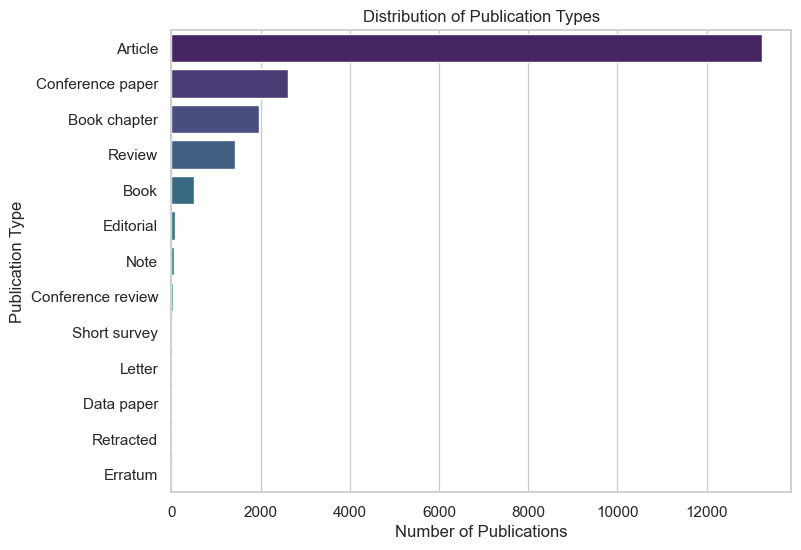

In [169]:
# df -> dataset
# opt -> whether the data is from the csv or from the api, to know which column name to search for
def plot_publication_types(df, opt):
    publication_type_counts = None
    if opt == 0:
        publication_type_counts = df['Document Type'].value_counts()
    elif opt == 1:
        publication_type_counts = df['publication_type'].value_counts()

        
    plt.figure(figsize=(8, 6))
    sns.barplot(x=publication_type_counts.values, y=publication_type_counts.index, palette="viridis")
    plt.title("Distribution of Publication Types")
    plt.xlabel("Number of Publications")
    plt.ylabel("Publication Type")
    plt.show()

plot_publication_types(CSV_DATA if CSV_DATA is not None else API_DATA, 0 if CSV_DATA is not None else 1)

#### Top Keywords
Only works with data from the CSV, has the standard API does not give data about the keywords

C:\Users\gilra\AppData\Local\Temp\ipykernel_7512\1930667531.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords.values, y=top_keywords.index, palette="coolwarm")


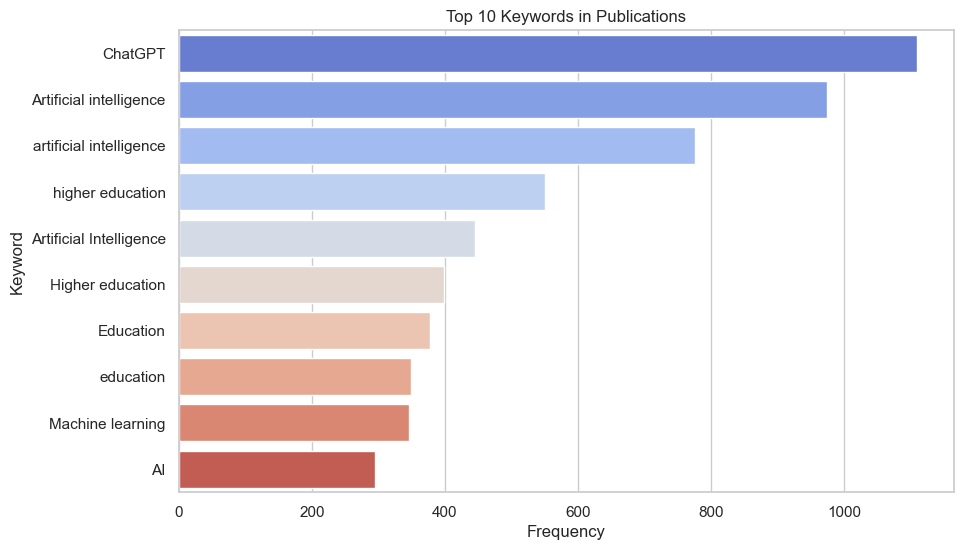

In [ ]:
def plot_top_keywords(df):
    all_keywords = [kw.strip() for keywords in df['Author Keywords'].dropna() for kw in keywords.split(';')]
    top_keywords = pd.Series(all_keywords).value_counts().head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_keywords.values, y=top_keywords.index, palette="coolwarm")
    plt.title("Top 10 Keywords in Publications")
    plt.xlabel("Frequency")
    plt.ylabel("Keyword")
    plt.show()

if CSV_DATA is not None:
    plot_top_keywords(CSV_DATA)

### Where?

#### Top journals and conferences

C:\Users\gilra\AppData\Local\Temp\ipykernel_7512\3463577392.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sources.values, y=top_sources.index, palette="magma")


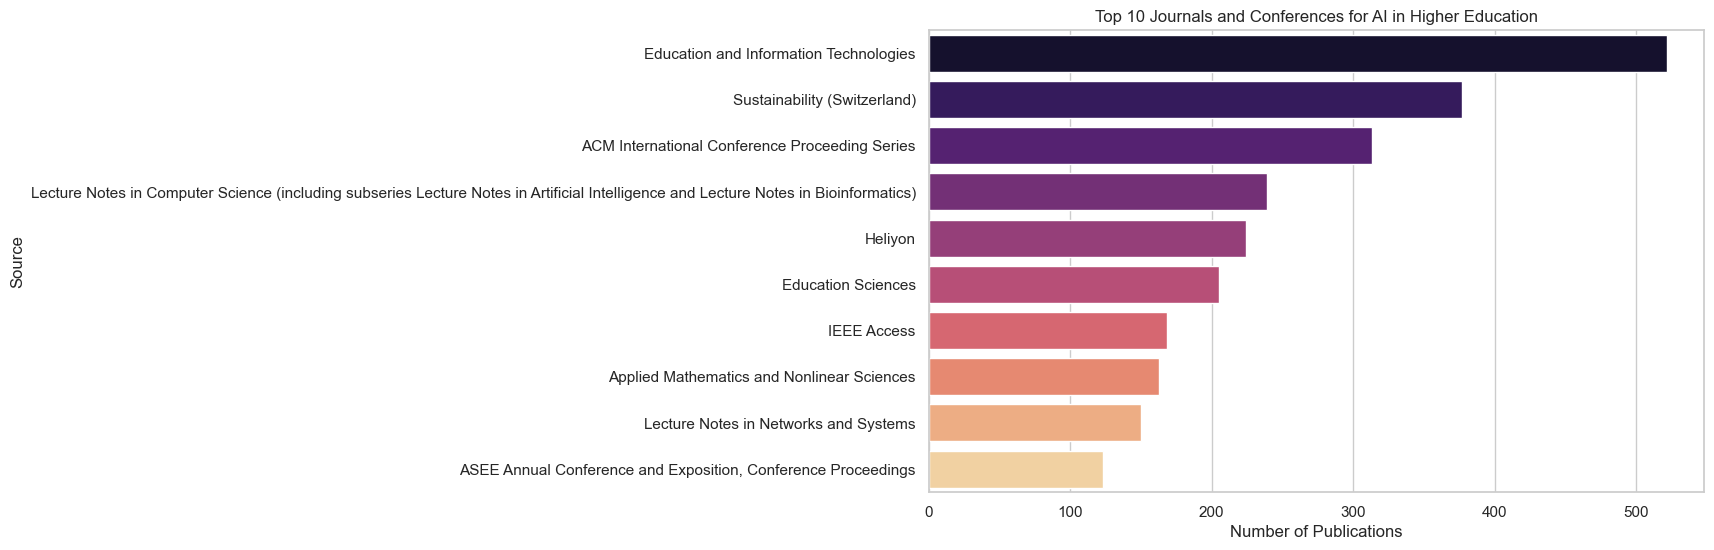

In [178]:
# df -> dataset
# opt -> whether the data is from the csv or from the api, to know which column name to search for
def plot_relevant_sources(df, opt):
    top_sources = df['Source title' if opt == 0 else 'publication_name'].value_counts().head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_sources.values, y=top_sources.index, palette="magma")
    plt.title("Top 10 Journals and Conferences for AI in Higher Education")
    plt.xlabel("Number of Publications")
    plt.ylabel("Source")
    plt.show()

plot_relevant_sources(CSV_DATA if CSV_DATA is not None else API_DATA, 0 if CSV_DATA is not None else 1)

#### Number of publications over time

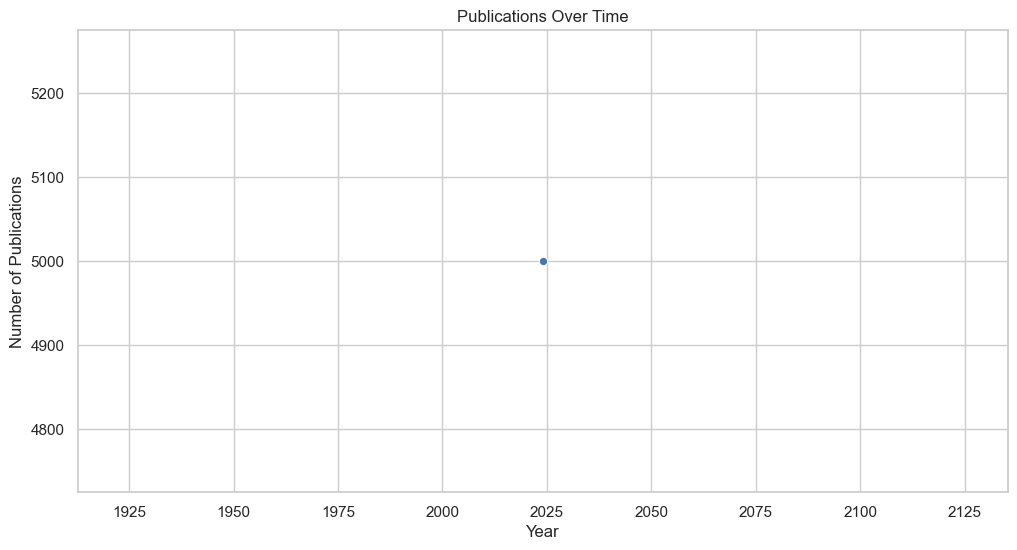

In [ ]:
def plot_publication_distribution(df):
    publications_per_year = df['Year'].value_counts().sort_index()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=publications_per_year.index, y=publications_per_year.values, marker="o", color="b")
    plt.title("Publications Over Time")
    plt.xlabel("Year")
    plt.ylabel("Number of Publications")
    plt.grid(True)
    plt.show()

plot_publication_distribution(CSV_DATA if CSV_DATA is not None else API_DATA, 0 if CSV_DATA is not None else 1)

### Who?

#### Most prominent authors
Only works with data from the CSV, has the standard API does not give data about the authors

C:\Users\gilra\AppData\Local\Temp\ipykernel_7512\3682376527.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=author_citations_series.values, y=author_citations_series.index, palette="coolwarm")


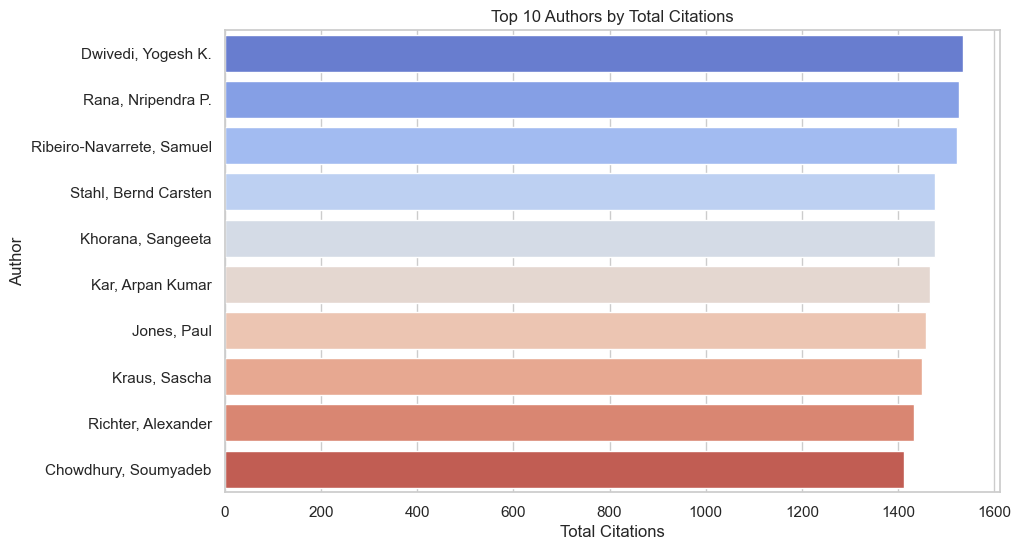

In [ ]:
def plot_most_prominent_authors(df):
    # Function to clean the names of the authors
    # They are stored like this: Kahlon, Yuval (57210749964);
    def clean_author_name(author_string):
        # regex to clean anything inside parentheses, parentheses included
        cleaned_name = re.sub(r'\(.*?\)', '', author_string).strip()
        return cleaned_name
    
    # Iterate over every article and get every participating author
    # Add the author to the dictionary (dictionaries don't allow duplicate keys) and increment its citations
    author_citations_dict = {}
    
    for _, row in df.iterrows():
        if isinstance(row['Author full names'], str) and row['Author full names'].strip() != '':
            authors = [clean_author_name(author.strip()) for author in row['Author full names'].split(';')]
            
            citation_count = row['Cited by']
            
            for author in authors:
                if author in author_citations_dict:
                    author_citations_dict[author] += citation_count
                else:
                    author_citations_dict[author] = citation_count
    
    author_citations_series = pd.Series(author_citations_dict).sort_values(ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=author_citations_series.values, y=author_citations_series.index, palette="coolwarm")
    plt.title("Top 10 Authors by Total Citations")
    plt.xlabel("Total Citations")
    plt.ylabel("Author")
    plt.show()

if CSV_DATA is not None:
    plot_most_prominent_authors(CSV_DATA)

#### Authors with the most publications
Only works with data from the CSV, has the standard API does not give data about the authors

C:\Users\gilra\AppData\Local\Temp\ipykernel_7512\318707677.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=author_counts.values, y=author_counts.index, palette="coolwarm")


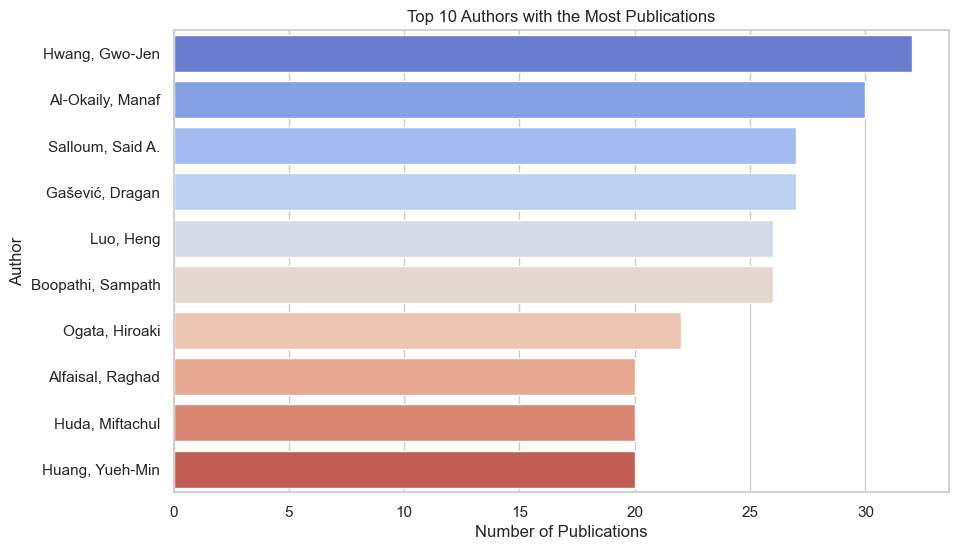

In [ ]:
def plot_authors_with_most_publications(df):
    # Function to clean the names of the authors
    # They are stored like this: Kahlon, Yuval (57210749964);
    def clean_author_name(author_string):
        # regex to clean anything inside parentheses, parentheses included
        cleaned_name = re.sub(r'\(.*?\)', '', author_string).strip()
        return cleaned_name
    
    # The names are stored as a string, so we split them up in individual names so we can count them
    authors_list = df['Author full names'].dropna().apply(lambda x: [clean_author_name(author.strip()) for author in x.split(';')])
    all_authors = [author for sublist in authors_list for author in sublist]
    
    author_counts = pd.Series(all_authors).value_counts().head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=author_counts.values, y=author_counts.index, palette="coolwarm")
    plt.title("Top 10 Authors with the Most Publications")
    plt.xlabel("Number of Publications")
    plt.ylabel("Author")
    plt.show()

if CSV_DATA is not None:
    plot_authors_with_most_publications(CSV_DATA)

#### Most prominent institutions

C:\Users\gilra\AppData\Local\Temp\ipykernel_7512\57860720.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=institution_counts.values, y=institution_counts.index, palette="plasma")


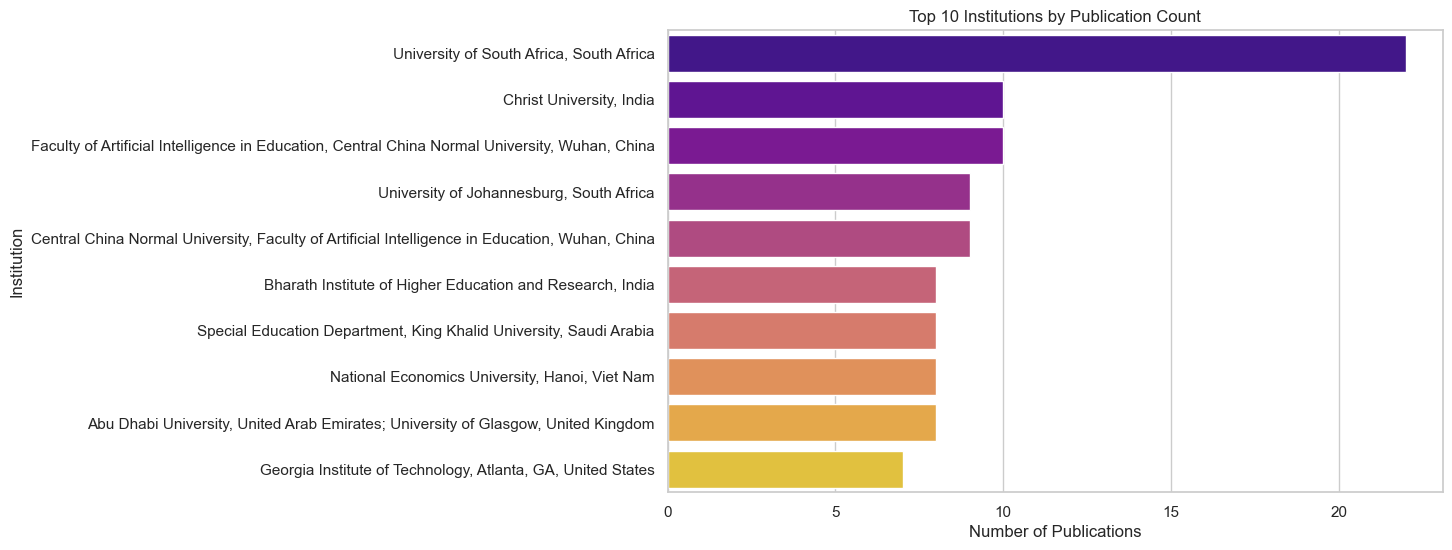

In [ ]:
# df -> dataset
# opt -> whether the data is from the csv or from the api, to know which column name to search for
def plot_top_institutions(df, opt):
    all_institutions = []
    
    if opt == 0:
        for _, row in df.iterrows():
            affiliation = str(row['Affiliations']).strip()
            if affiliation and affiliation.lower() != 'nan':  
                all_institutions.append(affiliation)
    
    elif opt == 1:
        if isinstance(df, pd.DataFrame):
            df = df.to_dict('records')
            
        for item in df:
            if isinstance(item, dict): 
                affiliations = item.get('affiliations', [])
                for affiliation in affiliations:
                    institution = affiliation.get('name', '')
                    if institution:
                        all_institutions.append(institution)

    if not all_institutions:
        print("No valid affiliations found.")
        return

    institution_counts = pd.Series(all_institutions).value_counts().head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=institution_counts.values, y=institution_counts.index, palette="plasma")
    plt.title("Top 10 Institutions by Publication Count")
    plt.xlabel("Number of Publications")
    plt.ylabel("Institution")
    plt.show()

plot_top_institutions(CSV_DATA if CSV_DATA is not None else API_DATA, 0 if CSV_DATA is not None else 1)

#### Most prominent countries

C:\Users\gilra\AppData\Local\Temp\ipykernel_7512\2834187301.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=countries_counts.values, y=countries_counts.index, palette="plasma")


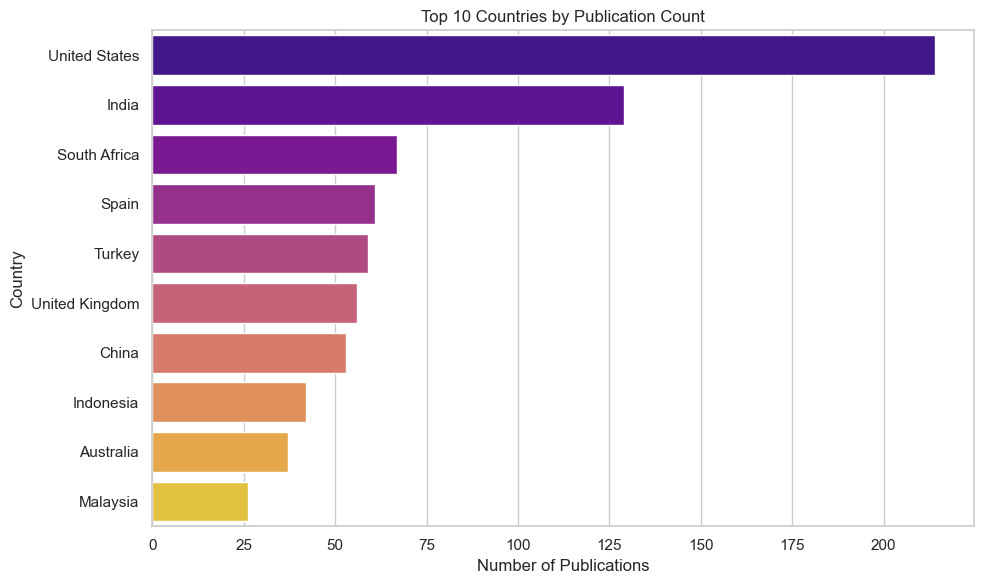

In [ ]:
# df -> dataset
# opt -> whether the data is from the csv or from the api, to know which column name to search for
def extract_countries(df, opt):
    countries_list = []

    if opt == 0:
        for _, row in df.iterrows():
            affiliation = str(row['Affiliations']).strip()
            if affiliation and affiliation.lower() != 'nan':
                parts = affiliation.split(',', 1)
                if len(parts) > 1:
                    country = parts[1].strip()
                    countries_list.append(country)
    
    elif opt == 1:
        if isinstance(df, pd.DataFrame):
            df = df.to_dict('records')
            
        for item in df:
            if isinstance(item, dict):
                affiliations = item.get('affiliations', [])
                for affiliation in affiliations:
                    country = affiliation.get('country', '')
                    if country:
                        countries_list.append(country)

    return countries_list

# df -> dataset
# opt -> whether the data is from the csv or from the api, to know which column name to search for
def plot_top_countries(df, opt):
    if isinstance(df, list):
        df = pd.DataFrame(df)
    
    countries = extract_countries(df, opt)
    
    if countries:
        countries_counts = pd.Series(countries).value_counts().head(10)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=countries_counts.values, y=countries_counts.index, palette="plasma")
        plt.title("Top 10 Countries by Publication Count")
        plt.xlabel("Number of Publications")
        plt.ylabel("Country")
        plt.tight_layout()
        plt.show()
    else:
        print("No country data found to plot")

plot_top_countries(CSV_DATA if CSV_DATA is not None else API_DATA, 0 if CSV_DATA is not None else 1)

#### Sponsorships and Funding
Only works with data from the CSV, has the standard API does not give data about the sponsorships

C:\Users\gilra\AppData\Local\Temp\ipykernel_7512\876153094.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sponsors.values, y=top_sponsors.index, palette="cividis")


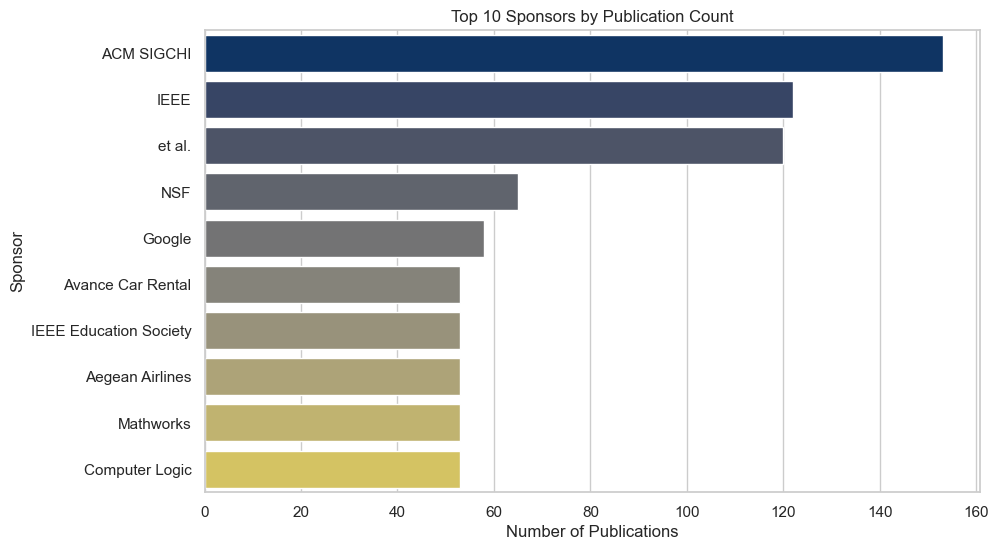

In [175]:
def plot_top_sponsors(df):
    all_sponsors = [sponsor.strip() for sponsors in df['Sponsors'].dropna() for sponsor in sponsors.split(';')]
    top_sponsors = pd.Series(all_sponsors).value_counts().head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_sponsors.values, y=top_sponsors.index, palette="cividis")
    plt.title("Top 10 Sponsors by Publication Count")
    plt.xlabel("Number of Publications")
    plt.ylabel("Sponsor")
    plt.show()

if CSV_DATA is not None:
    plot_top_sponsors(CSV_DATA)